# Handwritten Digits Generation Using GAN

* By using this project we can generate random numbers by GAN.
* The main aim is to create this one to familiarize with GAN and Use it real life application such as medical imaging, Text-to-Image Translation, Super-Resolution, Photo editing and many more.
* The GAN is Generative Adversarial Network.
* There will be two main components, the one will be Geneartor and another one will be Discriminator.
* Genearator creates random numbers by random noise and Discriminator identifies whether the image is matches or not.
* Here, we will be only use 40 epochs for to generate images however, It atleast requires 1000-200 epochs to get better results.

## Import Necessary Libraries

In [9]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import os
import tqdm

In [2]:
# Let keras know what engine you are using
os.environ['KERAS_BACKEND'] = 'tensorflow'

# To make sure we can reproduce the experiment and get the same result
np.random.seed(10)

# The dimension of our random noise vector
random_dim = 100

## Loading the Data

In [3]:
def load_data():
    # Load our data
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Normalizing our inputs to be in the range[-1, 1]
    X_train = (X_train.astype(np.float64) - 127.5) / 127.5
    
    # Converting X_train with a shape of(60000, 28, 28) to (60000, 784), for we have 784 columns per row
    X_train = X_train.reshape(60000, 784)
    
    return X_train, X_test, y_train, y_test

In [20]:
load_data()

(array([[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]), array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
    

* This is how our data looks like, when reshpaing and normalization gets done.

## Building a Generator Network

* This will generate random numbers from Original data and some Random noise data, by taking them equivalently together as iteration occurs more.

In [47]:
def get_optimizer():
    return Adam(learning_rate=0.0003, beta_1 = 0.5)

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim = random_dim, kernel_initializer = initializers.RandomNormal(stddev=0.01)))
    generator.add(LeakyReLU(0.3))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.3))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.3))
    
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

## Building a Discriminator Network

* This model will identify how the Generated Images looks like and how the Original Images looks like.

In [25]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer = initializers.RandomNormal(stddev=0.01)))
    discriminator.add(LeakyReLU(0.3))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.3))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.3))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator

## The GAN Model

* Now, this is our final model or main model which will compare Generator Loss and Discriminator Loss together.
* As the loss goes up for Generator that means Discriminator performs well.
* If the Discriminator Loss goes up that means Generator is performing good. 

In [36]:
def get_gan(generator, discriminator, optimizer, random_dim):
    # We will set trainable false at the beginning, since we only want to train either the generator or discriminator at a time.
    discriminator.trainable = False
    
    # Gan input noise will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    
    # Output of generator will be a random image
    X = generator(gan_input)
    
    # The output we will recieve from discriminator
    gan_output = discriminator(X)
    
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

## Plot Generated Images

* We will plot Generated images and will see how exactly it generated the output.
* We will also save images in current working directory.

In [55]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(15, 15)):
    noise = np.random.normal(0,1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for p in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], p+1)
        plt.imshow(generated_images[p], interpolation='nearest', cmap='gray_r')
        plt.axis('off') # On
    plt.tight_layout()
    plt.savefig(f'Generated image at epoch-{epoch}.png')

## Training the Model

* In final stage, we will train the model and will see how the Generated image is looks like.
* At each 20 epoch, we will save the images.

In [60]:
def train(epochs=40, batch_size=128):
    # Getting the training and test data
    X_train, X_test, y_train, y_test = load_data()
    
    # Splitting the data by batch size
    batch_count = X_train.shape[0] / batch_size
    
    # Building our gan network
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan(generator, discriminator, adam, random_dim)
    
    for f in range(1, epochs+1):
        print('-'*15, f'Epoch-{f}', '-'*15)
        
        for _ in range(int(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # Generate images from generator
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_disc = np.zeros(2*batch_size)
            # One side label smoothing
            y_disc[:batch_size] = 0.9
            
            # Train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_disc)
            
            # Train the generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            
        if f==1 or f % 20 == 0:
            plot_generated_images(f, generator)

--------------- Epoch-1 ---------------
4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 3ms/step
--------------- Epoch-2 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 4ms/step
--------------- Epoch-3 ---------------
4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 4ms/step
--------------- Epoch-4 ---------------
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 7ms/step
--------------- Epoch-5 ---------------
4/4 [==============================] - 0s 8ms/step


4/4 [==============================] - 0s 8ms/step


4/4 [==============================] - 0s 7ms/step
--------------- Epoch-6 ---------------
4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 7ms/step
--------------- Epoch-7 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 7ms/step
--------------- Epoch-8 ---------------
4/4 [==============================] - 0s 8ms/step


4/4 [==============================] - 0s 8ms/step
--------------- Epoch-9 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 4ms/step
--------------- Epoch-10 ---------------
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 2ms/step
--------------- Epoch-11 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 4ms/step
--------------- Epoch-12 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 8ms/step
--------------- Epoch-13 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 8ms/step


4/4 [==============================] - 0s 5ms/step
--------------- Epoch-14 ---------------
4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step
--------------- Epoch-15 ---------------
4/4 [==============================] - 0s 8ms/step


4/4 [==============================] - 0s 6ms/step
--------------- Epoch-16 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 4ms/step
--------------- Epoch-17 ---------------
4/4 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 5ms/step
--------------- Epoch-18 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 7ms/step
--------------- Epoch-19 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 7ms/step
--------------- Epoch-20 ---------------
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 8ms/step
--------------- Epoch-21 ---------------
4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 6ms/step
--------------- Epoch-22 ---------------
4/4 [==============================] - 0s 8ms/step


4/4 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 6ms/step
--------------- Epoch-23 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 5ms/step
--------------- Epoch-24 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 8ms/step


4/4 [==============================] - 0s 6ms/step
--------------- Epoch-25 ---------------
4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step
--------------- Epoch-26 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 7ms/step
--------------- Epoch-27 ---------------
4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 6ms/step
--------------- Epoch-28 ---------------
4/4 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 4ms/step
--------------- Epoch-29 ---------------
4/4 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 3ms/step
--------------- Epoch-30 ---------------
4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step
--------------- Epoch-31 ---------------
4/4 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 6ms/step
--------------- Epoch-32 ---------------
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 6ms/step
--------------- Epoch-33 ---------------
4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 5ms/step
--------------- Epoch-34 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 6ms/step
--------------- Epoch-35 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 3ms/step
--------------- Epoch-36 ---------------
4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 7ms/step
--------------- Epoch-37 ---------------
4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step
--------------- Epoch-38 ---------------
4/4 [==============================] - 0s 7ms/step


4/4 [==============================] - 0s 4ms/step
--------------- Epoch-39 ---------------
4/4 [==============================] - 0s 5ms/step


4/4 [==============================] - 0s 2ms/step


4/4 [==============================] - 0s 8ms/step
--------------- Epoch-40 ---------------
4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 6ms/step


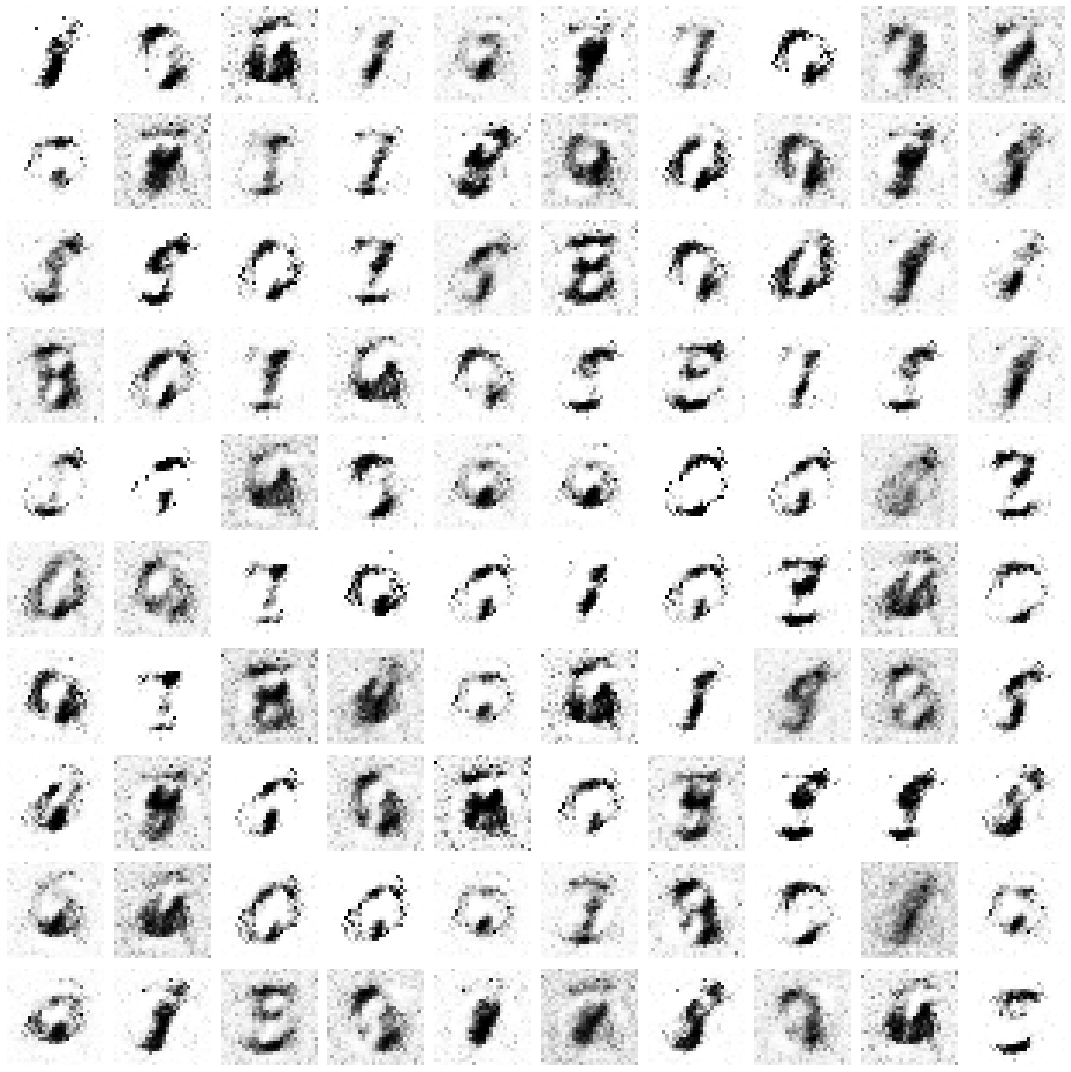

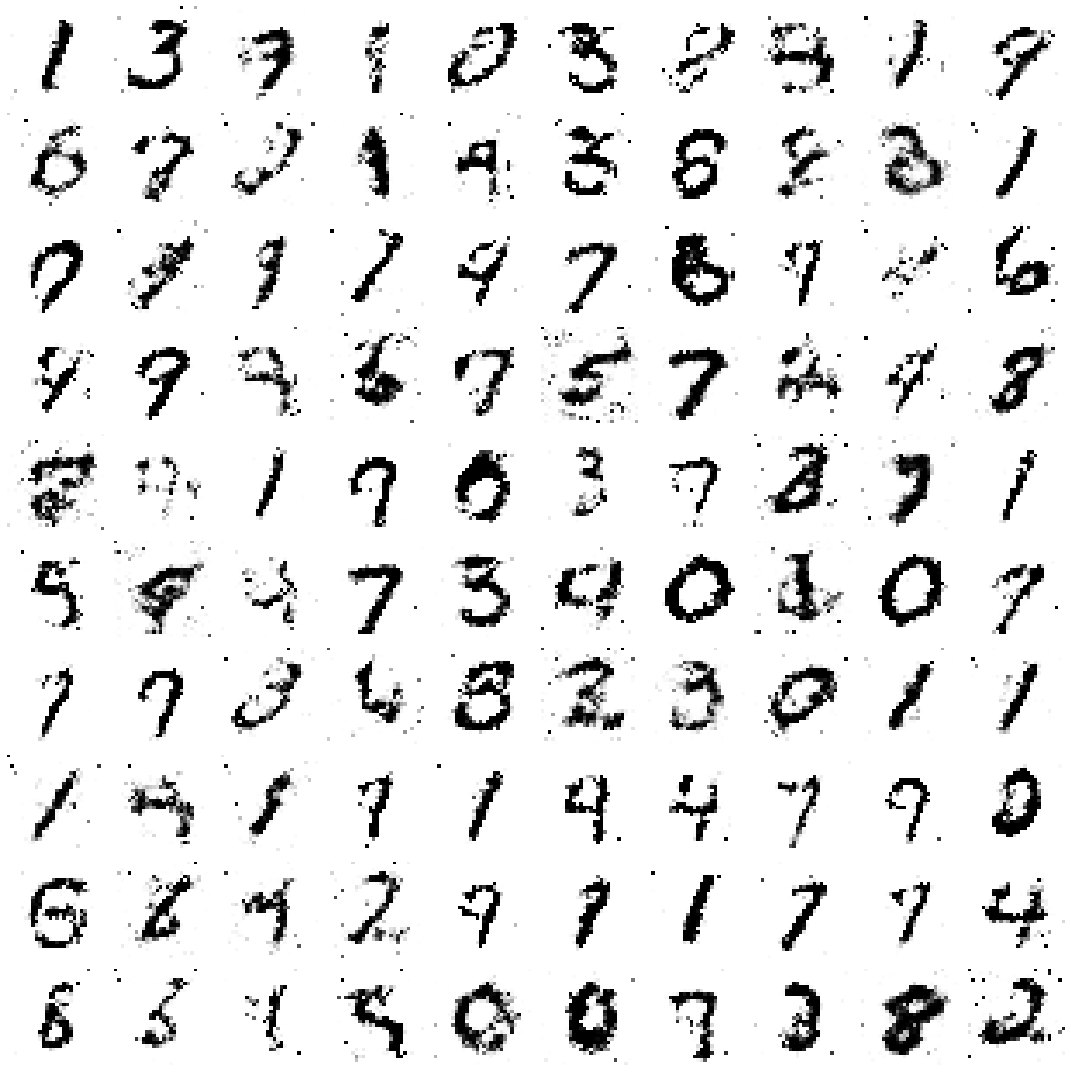

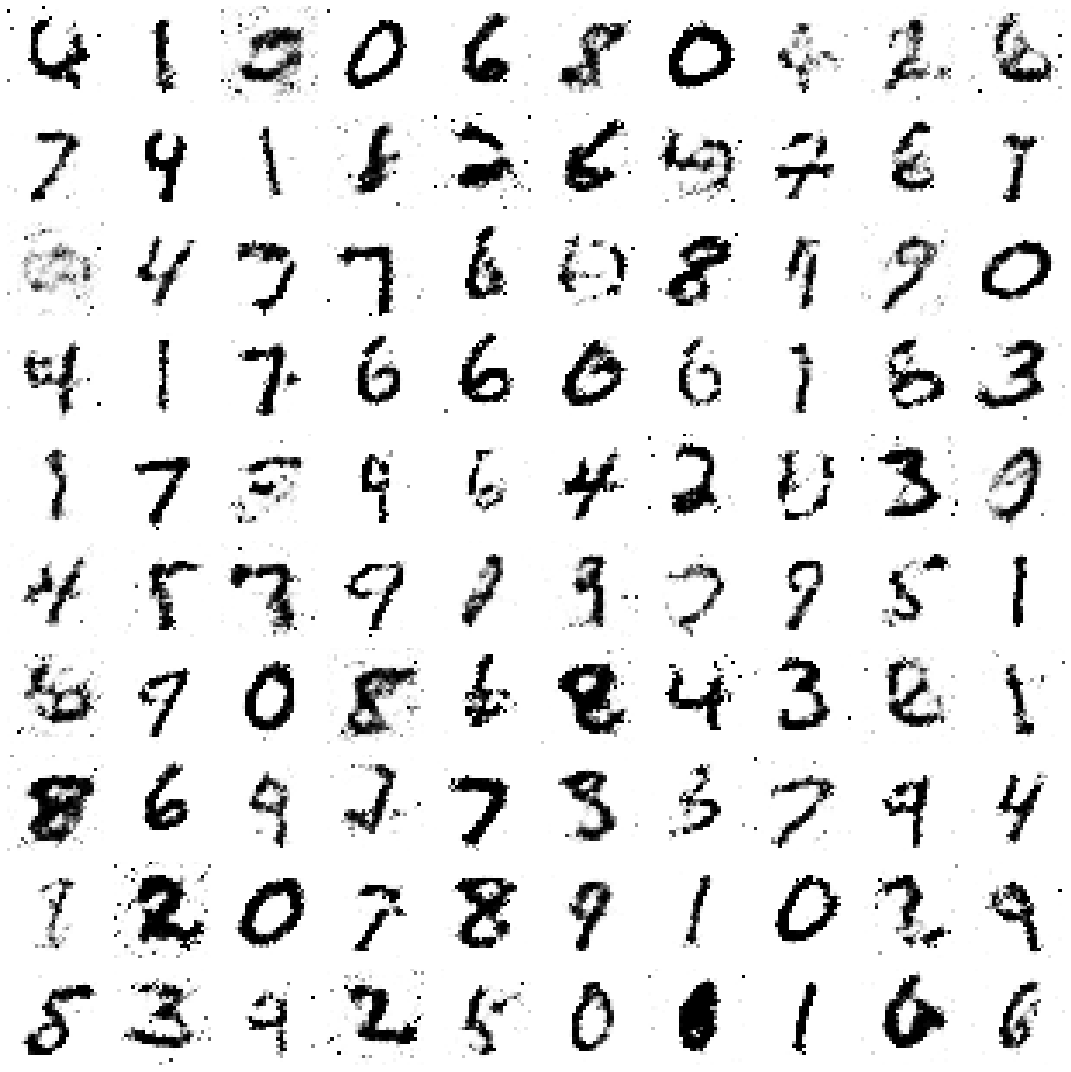

In [61]:
train()

* Finally, the output has been generated and it looks promising or as good as expected, but it requires to train more as said earlier.